# Loading software

In [2]:
from fretbursts import *
sns = init_notebook()
import lmfit
import phconvert
import os
from fretbursts.burstlib_ext import burst_search_and_gate

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


# Name and Load in data

first name the data file and check it exists, it will look for the file starting from inside the "Anaconda Projects Folder"

In [60]:
filename = "definitiveset/1x.hdf5"
if os.path.isfile(filename):
    print("File found")
else:
    print("File not found, check file name is correct")

File found


Load in the file and set correction coefficients

You may get warnings that some parameters are not defined in the file, this is fine as they will be defined in this workbook anyway

In [61]:
d = loader.photon_hdf5(filename)
d.leakage = 0.0
d.dir_ex = 0.0
d.gamma = 1.0
d.beta = 1.0

# Check alternation cycle is correct

We need to check that the ALEX parameters defined in the HDF5 file are appropriate for the laser cycle used in the experiment. If this is correct, the following histogram should look correct. It is a combined plot of every photon that arrives over the supplied alternation periods. 

In [155]:
# Check alternation cycle is correct

We need to check that the ALEX parameters defined in the HDF5 file are appropriate for the laser cycle used in the experiment. If this is correct, the following histogram should look correct. It is a combined plot of every photon that arrives over the supplied alternation periods. d.add(det_donor_accept = (0, 1),
    alex_period = 10000,
    offset = 0,
    D_ON = (0, 4500),
    A_ON = (5000, 9500))

If this is correct, the following histogram should look correct. It is a combined plot of every photon that arrives over the supplied alternation periods. 

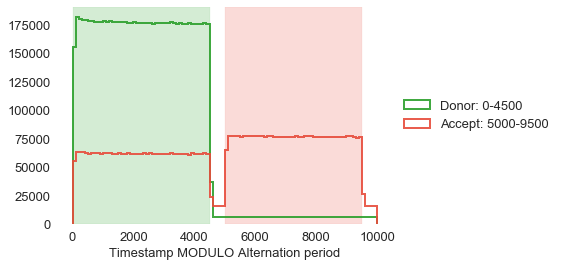

In [62]:
bpl.plot_alternation_hist(d)

IF THE ABOVE HISTOGRAM LOOKS CORRECT: then run loader.alex_apply_period, which rewrites the time stamps into groups based on their excitation period. If you want to change the alternation period after this you will have to reload the data into FRET bursts.

IF THE ABOVE HISTOGRAM LOOKS WRONG: then the supplied alternation parameters do not match up to the alternation of the lasers in the data. This could be because the lasers were actually on a different alternation, or because the data set doesn't start at zero so is frame shifted etc.

In this case, you can un-hash the code below and alter the parameters manually.

In [63]:
#d.add(det_donor_accept = (0, 1),
#    alex_period = 10000,
#    offset = 0,
#    D_ON = (0, 4500),
#    A_ON = (5000, 9500))

In [64]:
loader.alex_apply_period(d)
time = d.time_max
print('Total data time = %s'%time)

# Total photons (after ALEX selection):    14,487,665
#  D  photons in D+A excitation periods:    8,245,518
#  A  photons in D+A excitation periods:    6,242,147
# D+A photons in  D  excitation period:    10,735,826
# D+A photons in  A  excitation period:     3,751,839

Total data time = 10799.91651103


The following will plot a time trace of the first second of your experiment.

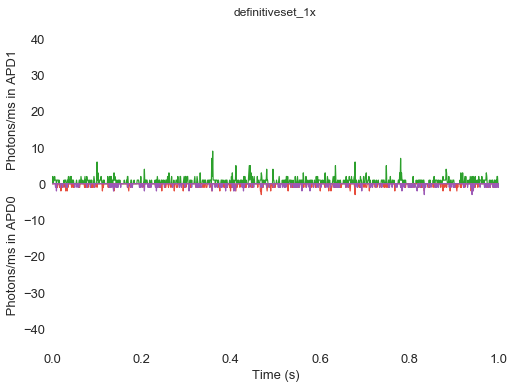

In [65]:
dplot(d, timetrace, binwidth=1e-3, tmin=0, tmax=15, figsize=(8,6))
plt.xlim(0,1);
plt.ylim(-45,45);

plt.ylabel(" Photons/ms in APD0       Photons/ms in APD1");

# Background Estimation

Background estimation works by plotting log of photons by the delay between them, assuming a poisson distribution of photon arrivals and fitting a line. The plot will contain single molecule bursts however, so a threshold (in microseconds) has to be defined where the fit begins. There are better ways of finding the threshold (TBD) but this will work for now

 - Calculating BG rates ... [DONE]


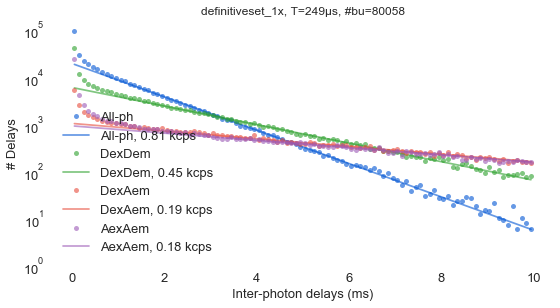

In [86]:
threshold = 1500
d.calc_bg(bg.exp_fit, time_s=300, tail_min_us=(threshold))
dplot(d, hist_bg, show_fit=True)

# Burst Searching and Selecting for Donor Only

M = the number of photons to look at at any time
F = the number of times higher than the background the photon rate must be to be considered a burst
L = the number of photons that must be in a burst to be considered a burst

The burst selection then selects only bursts that are size th1 or higher, and lower than th2. add_naa=True ensures acceptor photons under acceptor excitation are encluded in the search.

In [88]:
d.burst_search(L=10, m=10, F=45)
ds = d.select_bursts(select_bursts.size, add_naa=True, th1=50)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


# Analysis

now we can start plotting and fitting the data

The following command will plot a hexogram ES, note that it will likely throw up errors with donor only populations as there will not be sufficient data 

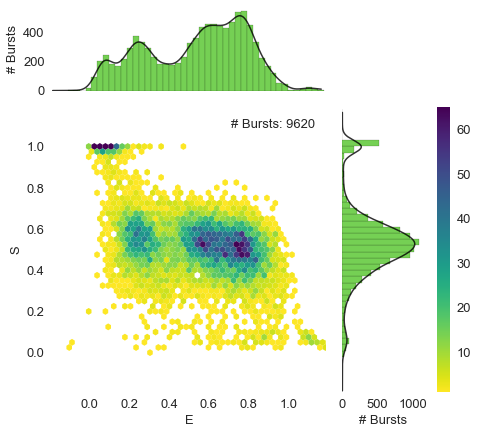

In [89]:
plt.rcParams['axes.facecolor'] = 'white'
grids = False
colourscheme = 'viridis_r'
g=alex_jointplot(ds, cmap=colourscheme, marginal_color=20, vmax_fret=True) 

Now we can draw a box around the population we want to analyse

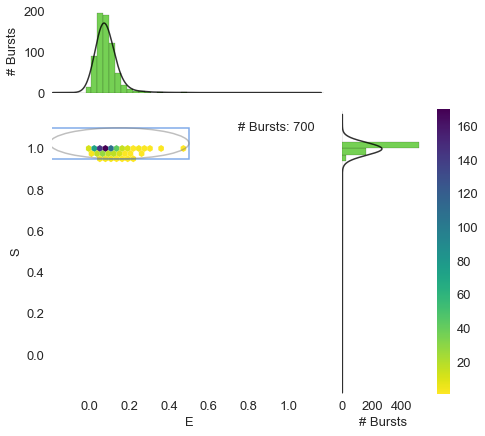

In [90]:
roi= dict(E1=-0.2, E2=0.5, S1=0.95, S2=1.1, rect=True)
ds3 = ds.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(ds3, cmap=colourscheme, marginal_color=20, vmax_fret=False)
bpl.plot_ES_selection(g.ax_joint, **roi);

This will fit a single gaussian to the filtered E, and convert the mean position to an alpha value, the leakage factor

alpha = 0.08096607511136686


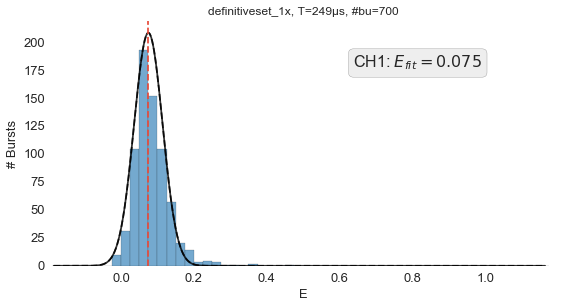

In [91]:
model = mfit.factory_gaussian()
ds3.E_fitter.fit_histogram(model=model, verbose=False, pdf=False)
dplot(ds3, hist_fret, binwidth=0.025, show_model=True, pdf=False, show_fit_value=True, fit_from="center");
params = ds3.E_fitter.params
Efit = params.to_dict()
Centre = Efit['center']
Edonly=Centre[0]
Edonly
alpha=Edonly/(1-Edonly)
print("alpha =", alpha)

# Selecting for AcceptorOnly

In [92]:
ds2 = d.select_bursts(select_bursts.size, add_naa=True, th1=50)

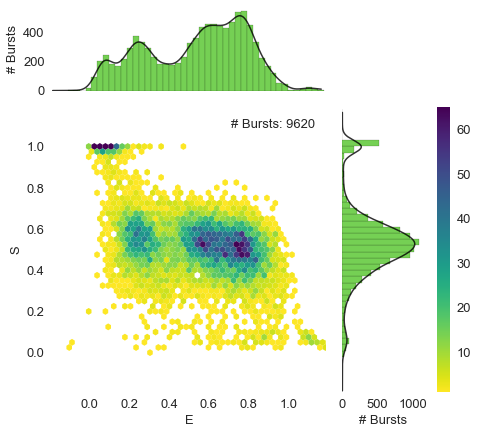

In [97]:
plt.rcParams['axes.facecolor'] = 'white'
grids = False
colourscheme = 'viridis_r'
g=alex_jointplot(ds2, cmap=colourscheme, marginal_color=20, vmax_fret=True) 

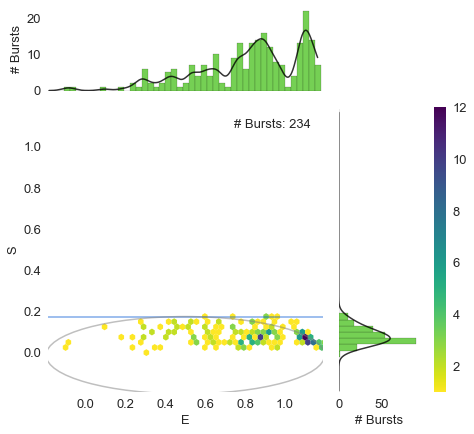

In [95]:
roi= dict(E1=-0.2, E2=1.2, S1=-0.2, S2=0.175, rect=True)
ds3 = ds2.select_bursts(select_bursts.ES, **roi)
g = alex_jointplot(ds3, cmap=colourscheme, marginal_color=20, vmax_fret=False)
bpl.plot_ES_selection(g.ax_joint, **roi);

This will extract delta, the direct excitation factor

delta = 0.07540089677411961


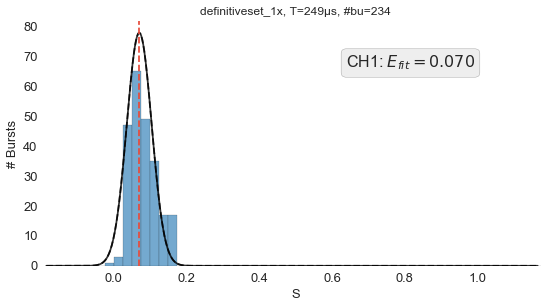

In [96]:
model = mfit.factory_gaussian()
ds3.S_fitter.fit_histogram(model=model, verbose=False, pdf=False)
dplot(ds3, hist_S, binwidth=0.025, show_model=True, pdf=False, show_fit_value=True, fit_from="center");
ds3.S_fitter.params
params = ds3.S_fitter.params
Sfit = params.to_dict()
Centre = Sfit['center']
Saonly=Centre[0]
delta=Saonly/(1-Saonly)
print("delta =", delta)